# Potato Disease Classification

In this project we will create a Convolutional Neural Network which will be able to predict whether a plant is suffering from a disease. We will use different layers and other hyperparameters for building, training and testing this classifictaion model.We will be using tensorflow and keras for this project.

In [1]:
#Data loading in tensorflow data set
#Visualization
#Train test split
#preprocessing - create layers - scaling, resizing, rotation and flip'''

In [2]:
#!pip install --upgrade tensorflow
#pip install numpy --upgrade
#!pip install opencv-python

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import matplotlib.image as mpimg
import random
from sklearn import preprocessing
import tensorflow.keras as keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [4]:
tf.get_logger().setLevel('ERROR')

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

## Import data into tensorflow dataset object

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\IOD_py_prg\Data\PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


#### As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

## Visualize some of the images from our dataset

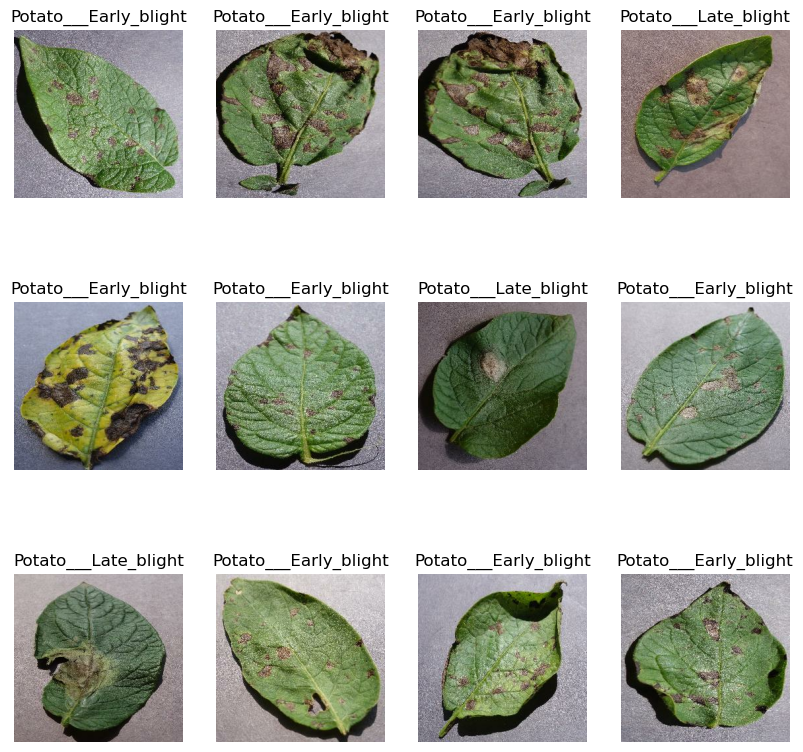

In [10]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

After visualizing the images let us move forward and create a function which will convert the images into a numpy array. It is required because we will normalize our dataset after this.

## Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:

Training: Dataset to be used while training

Validation: Dataset to be tested against while training

Test: Dataset to be tested against after we trained a model

In [11]:
# # Training data = 80%, testing data = 20% --> 10% is validation data and 10% is test data
# train_size = 0.8 #80% of training data
# len(dataset)*train_size #80% of length of dataset which is 68
# train_ds = dataset.take(54) #54 Batches
# test_ds = dataset.skip(54) #skip every 54 samples and select next 54 samples
# #10% validation data
# val_size = 0.1 
# len(dataset)*val_size
# val_ds = test_ds.take(6)
# len(dataset) #6 samples

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
       
        
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

## Cache, Shuffle, and Prefetch the Dataset

In [15]:
#Optimize data for training performance by caching and prefetching to run the training fast
#We will do caching on training dataset, this will read the image from the disk and for the next 
#iteration when you need the same image, it will keep the image in memory, this will improve the performance of pipeline.
#Shuffle will shuffle images 1000 times.
#Prefetch usig GPU and CPU, if GPU is busy training the next set of prefetch will load from the disk, this will improve 
#performance

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
test_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Building the Model
### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [17]:
#Perform scalling for pre-processing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [18]:
#Data augumentation by random flip and some rotation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Applying Data Augmentation to Train Dataset

In [19]:
print(tf.__version__) 
print(np.__version__) 
print(pd.__version__)

2.11.0
1.24.2
1.4.4


In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

Next we will create a network architecture for the model. We have used different types of layers according to their features namely Conv_2d (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel).

In [21]:
#Data is pre-processed and we are ready to Build the model using Convolutional neural network for image classification
#problem and train the network on trained dataset, to measure the accuracy using test data set.
#If accuracy is ok then will export the model to a file on a disk so that it can be used later on fast api based server 
#for making predictions.
CHANNELS = 3
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),    
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),    
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),    
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),    
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),    
    layers.MaxPooling2D((2,2)),
    layers.Flatten(), #Flatten layer for array of neurons
    layers.Dense(64, activation = 'relu'), #Hidden layer, Dense layer of 64 neurons 
    layers.Dense(n_classes, activation = 'softmax'), #Last layer - Dense layer with 3 neurons with soft max activation function, 
    #softmax activation function will normalize the probability of your classes
])

model.build(input_shape = input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

While compiling the model we need to set the type of loss which will be Binary Crossentropy for our model alongwith this we also need to set the optimizer and the metrics respectively.

In [23]:
#In deep learning we first define the architecture of neural network and then we complie using optimizers
#Adam is famous optimizer, then define Loss function and matrix for each epoch.
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'] #what type of metrics will be used to map the gradient descent basically - accuracy is the metric
    #used to track the training process
)


In [24]:
#Final step is to fit model - train the network

history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    verbose = 1,
    epochs = EPOCHS
)

Epoch 1/50
54/54 [==============================] - 48s 847ms/step - loss: 0.8958 - accuracy: 0.5017 - val_loss: 0.8459 - val_accuracy: 0.5573
Epoch 2/50
54/54 [==============================] - 48s 893ms/step - loss: 0.6105 - accuracy: 0.7436 - val_loss: 0.5065 - val_accuracy: 0.7656
Epoch 3/50
54/54 [==============================] - 52s 957ms/step - loss: 0.3877 - accuracy: 0.8380 - val_loss: 0.2958 - val_accuracy: 0.8698
Epoch 4/50
54/54 [==============================] - 81s 2s/step - loss: 0.2885 - accuracy: 0.8791 - val_loss: 0.2610 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 59s 1s/step - loss: 0.2549 - accuracy: 0.8906 - val_loss: 0.2316 - val_accuracy: 0.8906
Epoch 6/50
54/54 [==============================] - 65s 1s/step - loss: 0.2025 - accuracy: 0.9132 - val_loss: 0.2286 - val_accuracy: 0.8906
Epoch 7/50
54/54 [==============================] - 75s 1s/step - loss: 0.2055 - accuracy: 0.9184 - val_loss: 0.2831 - val_accuracy: 0.8698
Epoch 8/50


In [25]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 174ms/step - loss: 0.1080 - accuracy: 0.9609


In [26]:
scores

[0.10795512795448303, 0.9609375]

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

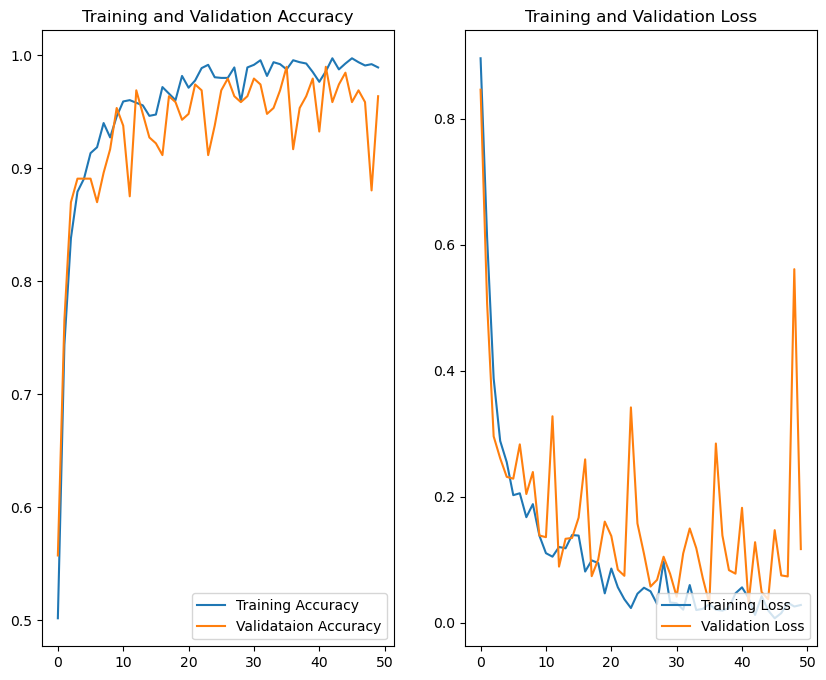

In [30]:
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validataion Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Loss')

First Image to Predict
Actual Label:  Potato___Early_blight
1/1 [==============================] - 0s 183ms/step
Predicted Label:  Potato___Early_blight


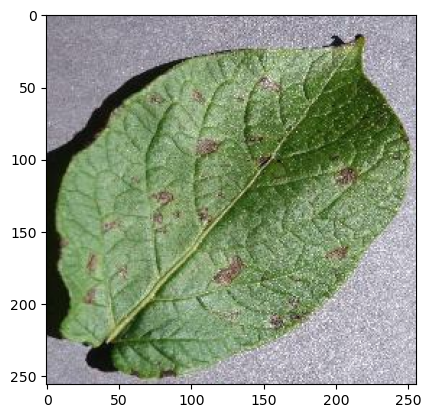

In [38]:
#Predictions
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First Image to Predict")
    plt.imshow(first_image)
    print("Actual Label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label: ", class_names[np.argmax(batch_prediction[0])])

In [39]:
#function to take image and model as input and telling what is predicted class and what is the confidence
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 29ms/step


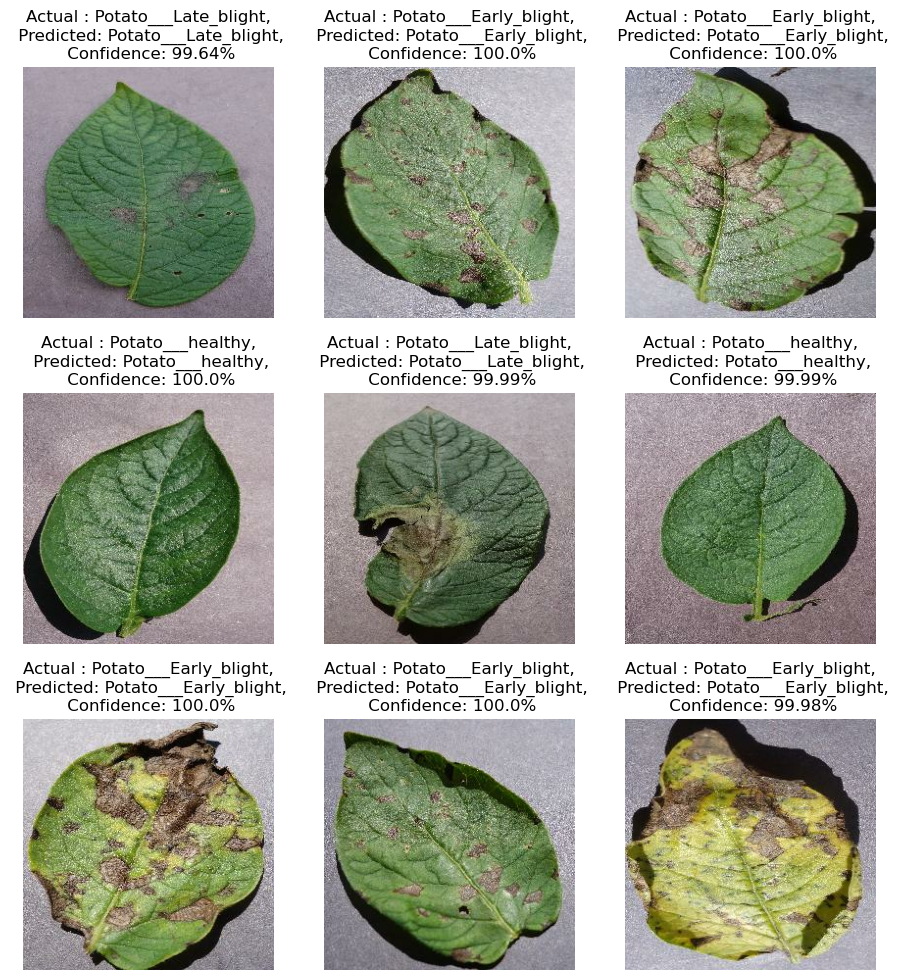

In [40]:
plt.figure(figsize = (11,12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual : {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")
            

In [41]:
import os
os.getcwd()

model_version = max([int(i) for i in os.listdir("models") + [0]]) + 1
model.save(f"saved_models/{model_version}")

In [42]:
# with open(r'C:\Users\sapta\Projects', 'wb') as f:
#     model_file = File(f)
#     pickle.dump(model.pk1, model_file)

In [43]:
model.save('final_model.h5')

In [44]:
import os
os.getcwd()

'C:\\Users\\sapta\\Projects'